# **Importando bibliotecas**

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
import holidays
import matplotlib.dates as mdates
import warnings

# instalar openpyxl para leitura dos arquivos excel (https://stackoverflow.com/a/56992903)

# **Importando dados**
Construí paths relativos independentes do sistema operacional para facilitar o uso por outros usuários.

In [2]:
# Lendo arquivos excel

# Obtendo o path deste notebook
current_dir = os.getcwd()

# Construindo o path para os arquivos excel
itens_path = os.path.join(current_dir, 'dados', 'itens.xlsx')
pedido_path = os.path.join(current_dir, 'dados', 'pedido.xlsx')
itens_pedido_path = os.path.join(current_dir, 'dados', 'itens_pedido.xlsx')

# Importando arquivos excel como dataframes
df_itens = pd.read_excel(itens_path)
df_pedido = pd.read_excel(pedido_path)
df_itens_pedido = pd.read_excel(itens_pedido_path)

# **Preparação dos Dados**
1. Renomear colunas de df_itens: 'ID_ITEM' e 'PRECO_ITEM'
2. Dropar colunas inúteis de df_pedido e df_itens_pedido: 'Unnamed: 0'
3. Adicionar coluna 'PRECO_ITEM' na tabela 'df_itens_pedido': utilize a tabela df_itens
4. Adicionar coluna 'PRECO_TOTAL_ITEM' na tabela df_itens_pedido: ela vai multiplicar PRECO_ITEM por QUANTIDADE
5. Adicionar coluna 'DATA' na tabela df_itens_pedido: utilizar a tabela df_pedido
6. PARA DESCOBRIR O PREÇO TOTAL POR PEDIDO:
    1. Agrupar a tabela df_itens_pedido por ID_PEDIDO, gerando uma nova tabela com as seguintes colunas:
        - ID_PEDIDO
        - DATA
        - PRECO_PEDIDO: é a soma das linhas em PRECO_TOTAL_ITEM para cada grupo de ID_PEDIDO
    2. Essa nova tabela pode se chamar df_pedidos
7. Verificar se os tipos de dados estão corretos.
    1. Converter coluna de data do formato 'object' para 'DateTime'
8. Extrair features (features engineering)

Consolidando dados em um único dataset 'df':

In [3]:
# renomear colunas de df_itens
df_itens = df_itens.rename(columns={
    'Unnamed: 0': 'ID_ITEM',
    0: 'PRECO_ITEM'
})

# descartar colunas Unnamed de df_pedido e df_itens_pedido
df_pedido = df_pedido.drop(columns='Unnamed: 0')
df_itens_pedido = df_itens_pedido.drop(columns='Unnamed: 0')

# adicionar 'PRECO_ITEM' na tabela 'df_itens_pedido' utilizando a tabela 'df_itens'
df_itens_pedido = df_itens_pedido.merge(df_itens, on='ID_ITEM')

# adicionar 'PRECO_TOTAL_ITEM' em 'df_itens_pedido'
df_itens_pedido['PRECO_TOTAL_ITEM'] = df_itens_pedido['QUANTIDADE'] * df_itens_pedido['PRECO_ITEM']

# adicionar coluna 'DATA' em 'df_itens_pedido' utilizando 'df_pedido'
df_itens_pedido = df_itens_pedido.merge(df_pedido, on='ID_PEDIDO')
df_itens_pedido = df_itens_pedido.drop(columns='VALOR_TOTAL')

# converter formato da coluna 'DATA'
df_itens_pedido['DATA'] = pd.to_datetime(df_itens_pedido['DATA'], format='%Y-%m-%d')
df_itens_pedido.dtypes

# Como a tabela principal é esta, vamos simplificar o nome
df = df_itens_pedido

# Mudar os nomes de colunas para letra minúscula
df.columns = df.columns.str.lower()

# Retirar a palavra 'item' de cada linha da coluna 'id_item'
df['id_item'] = df['id_item'].str.replace('item ', '', case=False)

# Mudar os nomes das colunas
df.columns = ['pedido', 'item', 'qtd', 'vlr_unitario', 'vlr_total', 'data']
df.head()

,pedido,item,qtd,vlr_unitario,vlr_total,data
0,120210601,C,4,20,80,2021-06-01
1,220210601,A,3,10,30,2021-06-01
2,320210604,C,1,20,20,2021-06-04
3,420210604,B,4,15,60,2021-06-04
4,420210604,C,2,20,40,2021-06-04


## **Feature Engineering**
O objetivo é converter um problema de séries temporais em um problema para algoritmos supervisionados de ML.
- features temporais: 
    - dia
    - mês
    - ano
    - dia da semana
    - é fim de semana?
    - é feriado?
    - semana do ano
    - trimestre do ano
    - features cíclicas: transformação seno e cosseno
- rolling windows features:
    - moving average

**Features temporais**

In [4]:
# Extraindo dia, mês e ano da data
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['dia'] = df['data'].dt.day

# Extraindo dia da semana e nome do dia
df['dia_semana'] = df['data'].dt.dayofweek # monday/segunda = 0
df['nome_dia'] = df['data'].dt.day_name()

# Traduzir nomes dos dias
nome_dia_traduzido = {
    'Monday': 'segunda-feira',
    'Tuesday': 'terça-feira',
    'Wednesday': 'quarta-feira',
    'Thursday': 'quinta-feira',
    'Friday': 'sexta-feira',
    'Saturday': 'sábado',
    'Sunday': 'domingo'
}

df['nome_dia'] = df['nome_dia'].replace(nome_dia_traduzido)

# Extraindo semana do ano, trimestre do ano
df['semana'] = df['data'].dt.isocalendar().week
df['trimestre'] = df['data'].dt.quarter

# é fim de semana?
df['fim_de_semana'] = (df['data'].dt.dayofweek > 4).astype(int) # se dia da semana > 4 (sexta = 4), então é weekend. Converte booleano p/int

# é feriado?
feriados = holidays.Brazil()
df['feriado'] = df['data'].isin(feriados).astype(int)

# cíclicas
# Como a empresa não funciona em feriados, existe ciclicidade na demanda. Logo, é útil transformar dados para suavizar os ciclos.
# Vamos transformar: dia_semana, semana e trimestre porque são cíclicos no tempo
df['sen_dia_semana'] = np.sin(2 * np.pi * df['dia_semana']/7)
df['cos_dia_semana'] = np.cos(2 * np.pi * df['dia_semana']/7)

df['sen_semana'] = np.sin(2 * np.pi * df['semana']/52)
df['cos_semana'] = np.cos(2 * np.pi * df['semana']/52)

df['sen_trimestre'] = np.sin(2 * np.pi * df['trimestre']/4)
df['cos_trimestre'] = np.cos(2 * np.pi * df['trimestre']/4)


# verifica se não trabalha em feriados (soma vai dar zero)
if df['feriado'].sum() > 0:
    print('Trabalha em feriados')
else:
    print('Não trabalha em feriados')

# verifica se não trabalha em finais de semana (soma vai dar zero)
if df['fim_de_semana'].sum() > 0:
    print('Trabalha em fds')
else:
    print('Não trabalha em fds')

print(df['data'].max())
print(df['data'].min())

# Deletando colunas irrelevantes
# coluna 'ano' porque os dados estão todos no mesmo ano ('2021')
# coluna 'feriado' porque a empresa nunca funciona em feriados

df = df.drop(columns=['feriado', 'ano'])

Não trabalha em feriados
Trabalha em fds
2021-09-01 00:00:00
2021-06-01 00:00:00


**Explorando padrões temporais**
- Verificar se existe algum padrão temporal com a variável 'qtd', como tendências diárias, semanais ou mensais.
- Faremos isso através da inspeção visual de gráficos

Analizando tendência de demanda por **dia** no ano.

/tmp/ipykernel_647/680422795.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotaciona labels
/tmp/ipykernel_647/680422795.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotaciona labels


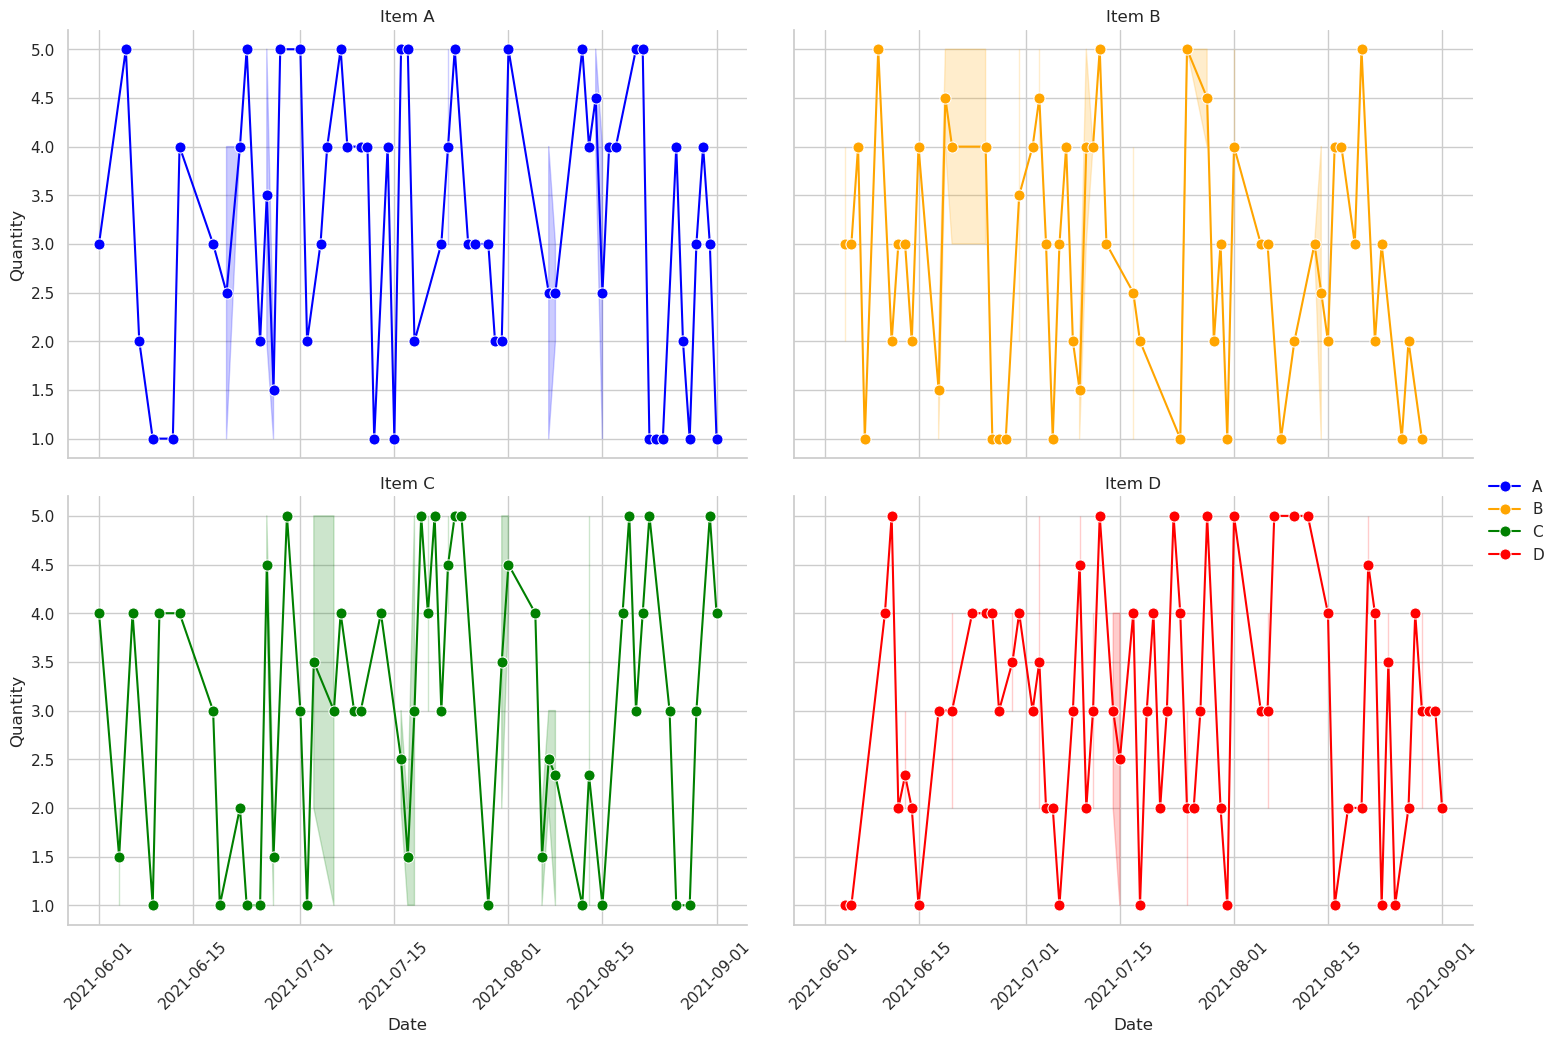

In [5]:
# Gráfico de Série Temporal: 'qtd' no tempo

# Cores distintas para items A, B, C, D
palette = {'A': 'blue', 'B': 'orange', 'C': 'green', 'D': 'red'}

# Ordem das colunas no gráfico
col_order = ['A', 'B', 'C', 'D']

# FacetGrid com Seaborn
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df, col="item", col_wrap=2, col_order=col_order, height=5, aspect=1.5, palette=palette.keys(), despine=True)
g.map_dataframe(sns.lineplot, x='data', y='qtd', hue='item', palette=palette, marker='o', markersize=8)
g.set_axis_labels("Date", "Quantity")
g.set_titles("Item {col_name}")
g.tight_layout()
g.add_legend()

# Rotacionando os labels do eixo x
for ax in g.axes.flatten():  # percorre todos os eixos
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # rotaciona labels

plt.show()

Analizando tendência de demanda por **semana.**

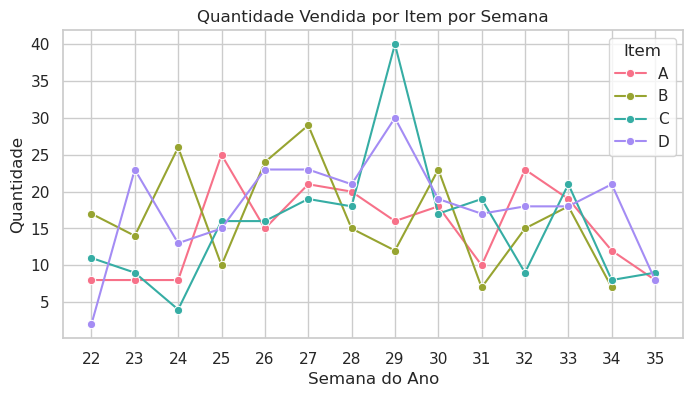

In [6]:
# Quantidade por semana

# Agrupar por semana e por item
df_weekly = df.groupby(['item', 'semana'])['qtd'].sum().reset_index()

# Plotar com Seaborn
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_weekly, x='semana', y='qtd', hue='item', marker='o', palette="husl")

plt.xlabel('Semana do Ano')
plt.ylabel('Quantidade')
plt.title('Quantidade Vendida por Item por Semana')
plt.legend(title='Item')
plt.xticks(df_weekly['semana'].unique())

plt.show()

Analizando a demanda por **mês**

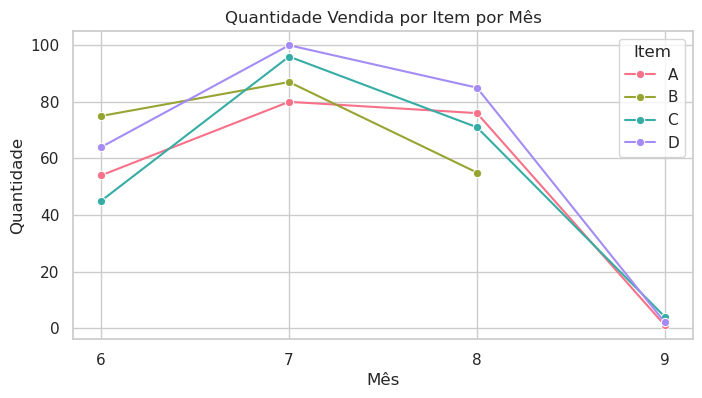

In [7]:
# Quantidade por mês

# Agrupar por mês e por item
df_monthly = df.groupby(['item', 'mes'])['qtd'].sum().reset_index()

# Plotar com Seaborn
plt.figure(figsize=(8, 4))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_monthly, x='mes', y='qtd', hue='item', marker='o', palette="husl")

plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.title('Quantidade Vendida por Item por Mês')
plt.legend(title='Item')
plt.xticks(df_monthly['mes'].unique())

plt.show()

**Médias Móveis:**
Elas ajudam a suavizar os dados, reduzir a dimensão e identificar mais facilmente tendências.

In [8]:
# Calcula médias móveis para cada item com períodos de 7 e 14 dias.
window_sizes = [7, 14]  # período em dias

for window in window_sizes:
    df[f'ma_qtd_{window}d'] = df.groupby('item')['qtd'].rolling(window=window).mean().reset_index(drop=True)

# **Análise Exploratória (EDA)**
Dos requisitos do projeto:

*Realizar uma análise descritiva para entender o comportamento das vendas, identificar padrões sazonais e outras características relevantes.*

É uma abordagem para analisar os dados utilizando técnicas visuais. Ela é usada para descobrir tendências, padrões ou para verificar hipóteses com a ajuda de resumos estatísticos e representações gráficas.

Adicionamos algumas features ao nosso dataset com base em algumas hipóteses. Agora, vamos verificar quais são as relações entre as diferentes features e a variável-resposta (quantidade).

In [9]:
# informações gerais da tabela: nomes de colunas, tamanho, tipos de dados
print('\nInformações gerais do dataset:')
df.info()

# quantidade de valores únicos
print('\nQuantidade de valores únicos:')
df.nunique()


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   pedido          295 non-null    int64         
 1   item            295 non-null    object        
 2   qtd             295 non-null    int64         
 3   vlr_unitario    295 non-null    int64         
 4   vlr_total       295 non-null    int64         
 5   data            295 non-null    datetime64[ns]
 6   mes             295 non-null    int32         
 7   dia             295 non-null    int32         
 8   dia_semana      295 non-null    int32         
 9   nome_dia        295 non-null    object        
 10  semana          295 non-null    UInt32        
 11  trimestre       295 non-null    int32         
 12  fim_de_semana   295 non-null    int64         
 13  sen_dia_semana  295 non-null    float64       
 14  cos_dia_semana  295 non-nu

pedido            181
item                4
qtd                 5
vlr_unitario        4
vlr_total          13
data               81
mes                 4
dia                31
dia_semana          7
nome_dia            7
semana             14
trimestre           2
fim_de_semana       2
sen_dia_semana      7
cos_dia_semana      7
sen_semana         14
cos_semana         13
sen_trimestre       2
cos_trimestre       2
ma_qtd_7d          18
ma_qtd_14d         25
dtype: int64

In [10]:
# estatísticas descritivas da tabela
print('Estatísticas descritivas:')
df[['item', 'qtd', 'vlr_unitario', 'vlr_total']].groupby('item').describe().round(2).T


Estatísticas descritivas:


item                    A      B       C       D
qtd          count  67.00  73.00   72.00   83.00
             mean    3.15   2.97    3.00    3.02
             std     1.45   1.39    1.53    1.33
             min     1.00   1.00    1.00    1.00
             25%     2.00   2.00    1.00    2.00
             50%     3.00   3.00    3.00    3.00
             75%     4.00   4.00    4.00    4.00
             max     5.00   5.00    5.00    5.00
vlr_unitario count  67.00  73.00   72.00   83.00
             mean   10.00  15.00   20.00   25.00
             std     0.00   0.00    0.00    0.00
             min    10.00  15.00   20.00   25.00
             25%    10.00  15.00   20.00   25.00
             50%    10.00  15.00   20.00   25.00
             75%    10.00  15.00   20.00   25.00
             max    10.00  15.00   20.00   25.00
vlr_total    count  67.00  73.00   72.00   83.00
             mean   31.49  44.59   60.00   75.60
             std    14.49  20.91   30.58   33.35
             min    10.00  15.00   20.00   25.00
             25%    20.00  30.00   20.00   50.00
             50%    30.00  45.00   60.00   75.00
             75%    40.00  60.00   80.00  100.00
             max    50.00  75.00  100.00  125.00

### Gráficos Descritivos

**Boxplots**: por dia, por semana e por mês.

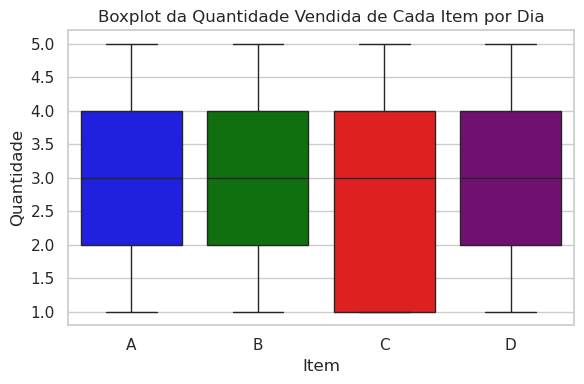

In [11]:
# Boxplot agregando dados diários

# Definindo cores para cada item
colors = {'A': 'blue', 'B': 'green', 'C': 'red', 'D': 'purple'}

# Gerar boxplots
plt.figure(figsize=(6, 4)) 

# Criando boxplots com a paleta customizada
sns.boxplot(data=df, x='item', y='qtd', hue='item', palette=colors, order=['A', 'B', 'C', 'D'], legend=False)

# Título e labels
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Boxplot da Quantidade Vendida de Cada Item por Dia')

plt.tight_layout()
plt.show()

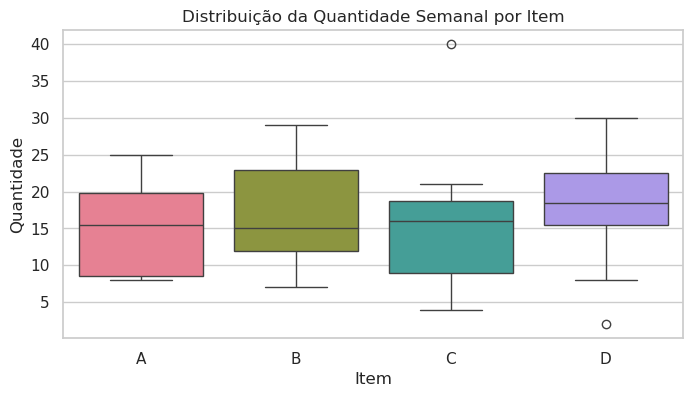

In [12]:
# # Boxplot agregando dados semanais
df_weekly_agg = df.groupby(['item', 'semana'], as_index=False, observed=False)['qtd'].sum()

# Plotando
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_weekly_agg, x='item', y='qtd', hue='item', palette='husl', legend=False)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Distribuição da Quantidade Semanal por Item')
plt.show()

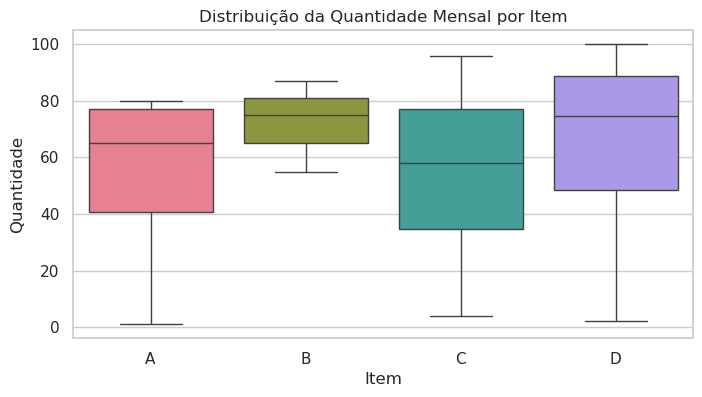

In [13]:
# # Boxplot agregando dados mensais
df_monthly_agg = df.groupby(['item', 'mes'], as_index=False, observed=False)['qtd'].sum()

# Plotando
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_monthly_agg, x='item', y='qtd', hue='item', palette='husl', legend=False)
plt.xlabel('Item')
plt.ylabel('Quantidade')
plt.title('Distribuição da Quantidade Mensal por Item')
plt.show()

## Perguntas de Negócio

1. ~~Qual a tendência de demanda de cada item? E a demanda generalizada (por todos os itens)? Plotar gráficos.~~
2. Qual o mês de maior demanda e de menor demanda para cada item?
3. Qual o dia da semana de maior demanda e de menor demanda para cada item?
4. Qual item tem a maior demanda? E a menor?
5. Como o preço influencia a demanda? Existe correlação entre o preço dos itens e a quantidade vendida?
6. Características dos pedidos: qual é a média de quantidade de itens por pedido? E o valor médio do pedido?
    - Qual é a média da quantidade de itens 'A', 'B', 'C' e 'D' por pedido? (*respondida nas estatísticas descritivas por item*)

(*essas perguntas vão nos ajudar a estimar quando cada item é mais demandado, permitindo trabalhar o estoque com maior precisão. Além disso, saberemos se o preço impacta na demanda e quais ítens são mais demandados*)

### 2. Qual o mês de maior demanda e de menor demanda para cada item?

In [27]:
# Encontrando o mês de maior e menor demanda para cada item
# Este código agrupa o dataframe por item e mês, ordena por item e qtd e exibe a primeira linha (maior/menor demanda)

# Agrupando por item e mês, somando a qtd
demanda_mes = df.groupby(['item', 'mes'])['qtd'].sum().reset_index()

# Maior demanda
maior_demanda_mes = demanda_mes.sort_values(['item', 'qtd'], ascending=[True, False]).groupby('item').head(1)
print('Mês com maior demanda para cada item:')
print(maior_demanda_mes)

# Menor demanda
menor_demanda_mes = demanda_mes.sort_values(['item', 'qtd'], ascending=[True, True]).groupby('item').head(1)
print('\nMês com menor demanda para cada item:')
print(menor_demanda_mes)

Mês com maior demanda para cada item:
   item  mes  qtd
1     A    7   80
5     B    7   87
8     C    7   96
12    D    7  100

Mês com menor demanda para cada item:
   item  mes  qtd
3     A    9    1
6     B    8   55
10    C    9    4
14    D    9    2


### 3. Qual o dia da semana com maior demanda e menor demanda para cada item?
Neste caso, em vez de calcular a soma da qtd por dia da semana, eu vou examinar a qtd MÉDIA vendida por dia da semana, por ítem.

In [45]:
# Agrupando por item e dia da semana, calculando a média da qtd
demanda_dia_semana = df.groupby(['item', 'nome_dia'])['qtd'].mean().round(2).reset_index()

# Maior demanda média
print('Dia da semana com maior demanda média para cada item:')
print(demanda_dia_semana.sort_values(['item', 'qtd'], ascending=[True, False]).groupby('item').head(1))

# Menor demanda média
print('\nDia da semana com menor demanda média para cada item:')
print(demanda_dia_semana.sort_values(['item', 'qtd'], ascending=[True, False]).groupby('item').tail(1))

Dia da semana com maior demanda média para cada item:
   item       nome_dia   qtd
2     A   quinta-feira  3.57
8     B   quarta-feira  4.17
17    C  segunda-feira  5.00
25    D    sexta-feira  3.44

Dia da semana com menor demanda média para cada item:
   item       nome_dia   qtd
0     A        domingo  2.62
9     B   quinta-feira  2.20
18    C    sexta-feira  2.38
24    D  segunda-feira  2.38


### 4. Qual item tem a maior demanda? E a menor?

In [46]:
# Agrupando por item e somando a qtd
demanda_total = df.groupby(['item'])['qtd'].sum().reset_index()

# Ordenando a demanda em ordem decrescente
demanda_total = demanda_total.sort_values('qtd', ascending=False)

print('O item com maior demanda no período foi:')
print(demanda_total.head(1))

print('\nO item com menor demanda no período foi:')
print(demanda_total.tail(1))

O item com maior demanda no período foi:
  item  qtd
3    D  251

O item com menor demanda no período foi:
  item  qtd
0    A  211


### 5. Como o preço influencia a demanda?
Vamos verificar se há correlação entre preço e demanda.

In [23]:
# Agrupando por quantidade e preço médio de cada item
item_summary = df.groupby('item').agg({
    'qtd': 'sum',             
    'vlr_unitario': 'mean'    
}).reset_index()

# Calculando correlação
correlation = item_summary['qtd'].corr(item_summary['vlr_unitario'])

print(f"Correlação entre qtd_sold e vlr_unitario: {correlation:.4f}")

# Filtrando o outlier item 'D'
item_summary_filtered = item_summary[item_summary['item'] != 'D']

# Calculando correlação
correlation = item_summary_filtered['qtd'].corr(item_summary_filtered['vlr_unitario'])

print(f"Correlação entre qtd_sold e vlr_unitario (sem item D): {correlation:.4f}")

Correlação entre qtd_sold e vlr_unitario: 0.8370
Correlação entre qtd_sold e vlr_unitario (sem item D): 0.7777


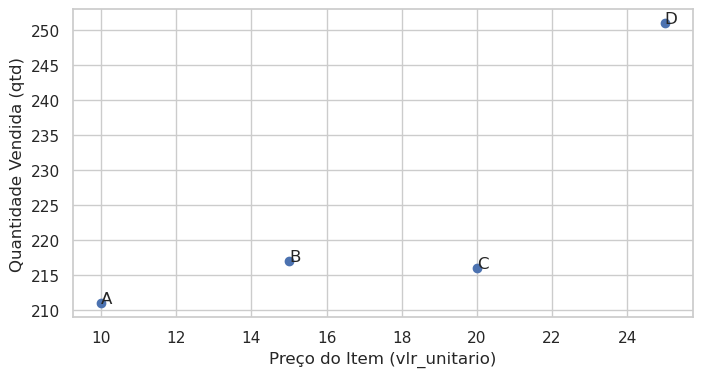

In [18]:
# Plotando gráfico de qtd x preço de cada item, para avaliar linearidade

# Preparando gráfico
plt.figure(figsize=(8, 4))
plt.scatter(item_summary['vlr_unitario'], item_summary['qtd'], marker='o', color='b')

# Labels e título
plt.xlabel('Preço do Item (vlr_unitario)')
plt.ylabel('Quantidade Vendida (qtd)')
# plt.title('Scatter Plot of Item Price vs. Quantity Sold')

# Adicionando o nome de cada ítem
for i, txt in enumerate(item_summary['item']):
    plt.annotate(txt, (item_summary['vlr_unitario'][i], item_summary['qtd'][i]), fontsize=12)

plt.grid(True)
plt.show()

### 6. Características dos pedidos: qual é a média de quantidade de itens por pedido? E o valor médio do pedido?
- Também: qual é a média da quantidade de itens 'A', 'B', 'C' e 'D' por pedido? (*respondida nas estatísticas descritivas por item*)

In [76]:
# Média da quantidade de itens por pedido
print('Quantidade média de itens por pedido:')
print(df.groupby('pedido')['qtd'].sum().mean().round(2))

# Valor médio dos pedidos
print('\nValor médio dos pedidos:')
print(df.groupby('pedido')['vlr_total'].sum().mean().round(2))

# Qual a quantidade média de cada item em um pedido típico?
avg_itens = df.groupby(['item'])['qtd'].mean().round().reset_index()
avg_itens.columns = ['item', 'qtd_média_por_ordem']
print('\nQuantidade média de cada item em um pedido típico:')
print(avg_itens)

Quantidade média de itens por pedido:
4.94

Valor médio dos pedidos:
88.18

Quantidade média de cada item em um pedido típico:
  item  qtd_média_por_ordem
0    A                  3.0
1    B                  3.0
2    C                  3.0
3    D                  3.0


# Modelagem
1. Identificar o tipo de problema: previsão (forecasting)
2. Escolher modelos de ML adequados ao problema. Devido às restrições de deadline optei por modelos mais rápidos de implementar e interpretar:
    - Regressão Linear (talvez)
    - Random Forest
    - XGBoost
    - Média Móvel
3. Escolher modelo baseline: o mais simples possível (média)
4. Separar dados em treino e teste
5. Coletar performance para cada modelo escolhido: avaliar métricas adequadas p/os modelos escolhidos
    - MAE
    - MAPE
    - RMSE
    - R-squared
6. Escolhido o modelo, fazer o *fine tunning* dele (cuidado com overfitting)
7. Coletar a performance do modelo otimizado (métricas e gráfico de previsão x resultado real) e salvar o modelo para não precisar treiná-lo novamente.